### **`plot_fig05_indoor_temp_setpoint.ipynb`**

Fig. 5: Indoor temperature trajectories on the evaluation set for the best controllers across T01--T04 with dynamic setpoints.

This script generates a LaTeX/TikZ figure showing the indoor temperature trajectories of the best-performing controllers, identified through an ablation study of various RL algorithms. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

# PGF setup for LaTeX-compatible plots
matplotlib.use("pgf")
matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "text.usetex": True,
        "font.family": "serif",
        "pgf.rcfonts": False,
        "font.size": 11.5,
    }
)
style.use("tableau-colorblind10")
%matplotlib inline

# Step 1: Load evaluation data (LLLEC measurements) from CSVs
data_dirs = ["../results/temperature/outdoor_data"]
# data_dirs = ["results/temperature", "results/combined"] # train

results = {}
avg_rewards = {}
valid_suffixes = ("_best.csv", "PID_Control.csv", "PI_Control.csv", "Fuzzy_Control.csv")

for results_dir in data_dirs:
    # Logging current results directory
    print(f"\n===== Processing directory: {results_dir} =====")

    if not os.path.isdir(results_dir):
        print(f"  [WARN] Directory '{results_dir}' does not exist.")
        continue

    # local container, only for this one directory
    dir_results = {}
    dir_avg_rewards = {}

    for filename in sorted(os.listdir(results_dir)):
        if filename.endswith(valid_suffixes) or (
            "MPC_Control" in filename and filename.endswith(".csv")
        ):
            file_path = os.path.join(results_dir, filename)
            model_name = (
                filename.replace("eval_", "")
                .replace(".csv", "")
                .replace("_", " ")
                .strip()
            )

            try:
                df = pd.read_csv(file_path, engine="python", on_bad_lines="error")
                df.columns = df.columns.str.strip()
                avg_reward = df.groupby("episode")["reward"].sum().mean()

                dir_results[model_name] = df
                dir_avg_rewards[model_name] = avg_reward
            except Exception as e:
                print(f"  Fehler beim Einlesen von '{filename}': {e}")

    # Overview for this directory
    unique_algorithms = list(dir_results.keys())
    print(f"  Anzahl verschiedener Algorithmen: {len(unique_algorithms)}")
    print("  Liste der Algorithmen:")
    for alg in unique_algorithms:
        print(f"  - {alg}")

    # Add global containers
    results.update(dir_results)
    avg_rewards.update(dir_avg_rewards)
# Step 2: Build summary
summary_list = []

for algo_name, df in results.items():
    # Define base name
    if "a2c" in algo_name:
        base_algo = "A2C"
    elif "ppo" in algo_name:
        base_algo = "PPO"
    elif "sac" in algo_name:
        base_algo = "SAC"
    elif "ddpg" in algo_name:
        base_algo = "DDPG"
    elif "Fuzzy" in algo_name:
        base_algo = "FUZZY"
    elif "PI" in algo_name and "PID" not in algo_name:
        base_algo = "PI"
    elif "PID" in algo_name:
        base_algo = "PID"
    elif "Perfect MPC" in algo_name:
        base_algo = "PERFECT MPC"
    elif "MPC" in algo_name:
        base_algo = "MPC"
    else:
        base_algo = algo_name.upper()  # Fallback

    # Extract last line per episode
    last_steps = df[df["time_step"] == df["time_step"].max()]
    for _, row in last_steps.iterrows():
        summary_list.append(
            {
                "Algorithm": algo_name,
                "Base Algorithm": base_algo,
                "Episode": row["episode"],
                "Seed": row["seed"],
                "Final Cumulative Reward": row["cumulative_reward"],
            }
        )

summary_df = pd.DataFrame(summary_list)


# Step 3: Readable labels (optional, unchanged)
def clean_label(name):
    if "best" in name and name.startswith("T"):
        parts = name.split()
        if len(parts) >= 3:
            return f"{parts[0]} ({parts[1].upper()})"
    return name


summary_df["Algorithm Clean"] = summary_df["Algorithm"].apply(clean_label)

# Output overview
unique_algorithms = summary_df["Algorithm"].unique()
print(f"Number of unique algorithms: {len(unique_algorithms)}")
print("List of algorithms:")
for alg in unique_algorithms:
    print(f"- {alg}")

# Prepare cumulative reward summary
summary_list = []
for algo, df in results.items():
    summary = df.groupby(["episode", "seed"], as_index=False).agg(
        {"time_step": "max", "cumulative_reward": "max"}
    )
    summary["algorithm"] = algo
    summary_list.append(summary)

all_summary = pd.concat(summary_list, ignore_index=True)
all_summary.rename(columns={"cumulative_reward": "Cumulative Reward"}, inplace=True)

# Compute mean and std per algorithm
reward_stats = (
    all_summary.groupby("algorithm")["Cumulative Reward"]
    .agg(["mean", "std"])
    .reset_index()
)
reward_stats = reward_stats.sort_values(by="mean", ascending=False)

# Identify best-performing algorithm
best_algo = reward_stats.iloc[0]
print("▶️ Best-performing algorithm:")
print(
    f"{best_algo['algorithm']} – Mean Reward: {best_algo['mean']:.2f} ± {best_algo['std']:.2f}"
)

# Print full table
print("\n🔢 Sorted Cumulative Reward Statistics:")
print(
    reward_stats.to_string(
        index=False, formatters={"mean": "{:.2f}".format, "std": "{:.2f}".format}
    )
)


===== Processing directory: ../results/temperature/outdoor_data =====
  Anzahl verschiedener Algorithmen: 21
  Liste der Algorithmen:
  - T01 Fuzzy Control
  - T01 MPC Control 12
  - T01 PID Control
  - T01 PI Control
  - T01 Perfect MPC Control 12
  - T01 a2c best
  - T01 ddpg best
  - T01 ppo best
  - T01 sac best
  - T02 a2c best
  - T02 ddpg best
  - T02 ppo best
  - T02 sac best
  - T03 a2c best
  - T03 ddpg best
  - T03 ppo best
  - T03 sac best
  - T04 a2c best
  - T04 ddpg best
  - T04 ppo best
  - T04 sac best
Number of unique algorithms: 21
List of algorithms:
- T01 Fuzzy Control
- T01 MPC Control 12
- T01 PID Control
- T01 PI Control
- T01 Perfect MPC Control 12
- T01 a2c best
- T01 ddpg best
- T01 ppo best
- T01 sac best
- T02 a2c best
- T02 ddpg best
- T02 ppo best
- T02 sac best
- T03 a2c best
- T03 ddpg best
- T03 ppo best
- T03 sac best
- T04 a2c best
- T04 ddpg best
- T04 ppo best
- T04 sac best
▶️ Best-performing algorithm:
T01 Perfect MPC Control 12 – Mean Reward: 2

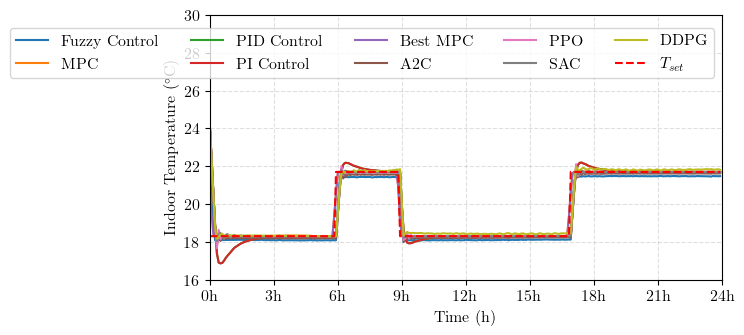


%---------- BEGIN TIKZ FIG TEMPERATURE CONTROL Fig. 05 ----------
\begin{figure}[!t]
  \centering
  \begin{tikzpicture}
    \begin{axis}[
      width=\columnwidth,
      height=3cm,
      xmin=0, xmax=288,
      ymin=16, ymax=24,
      xlabel={Time (h)},
      ylabel={Indoor Temp ($^\circ$C)},
      xtick={ 0,36,72,108,144,180,216,252,288 },
      ytick={16,18,20,22,24},
      xticklabels={0,3,6,9,12,15,18,21,24},
      grid=both,
      tick label style={font=\small},
      label style={font=\small},
      legend style={at={(0.5,1.04)}, anchor=south,
                    legend columns=5, font=\footnotesize, draw=white, fill=white, rounded corners},
      legend image post style={scale=0.45},
    ]

\addplot[blue, thick] coordinates {(0,21.16) (1,19.30) (2,18.47) (3,18.32) (4,18.30) (5,18.30) (6,18.30) (7,18.30) (8,18.30) (9,18.30) (10,18.30) (11,18.30) (12,18.30) (13,18.30) (14,18.30) (15,18.30) (16,18.30) (17,18.30) (18,18.30) (19,18.30) (20,18.30) (21,18.30) (22,18.30) (23,18.30) (2

In [2]:
# Select models to be plotted
selected_models = [
    "T01 Perfect MPC Control 12",
    "T03 sac best",
    "T03 ppo best",
    "T01 MPC Control 12",
    "T01 PI Control",
    "T01 PID Control",
    "T04 ddpg best",
    "T02 a2c best",
    "T01 Fuzzy Control",
]

# Short legend labels
legend_name_map = {
    "T01 Fuzzy Control": "Fuzzy Control",
    "T01 MPC Control 12": "MPC",
    "T01 Perfect MPC Control 12": "Best MPC",
    "T01 PID Control": "PID Control",
    "T01 PI Control": "PI Control",
    "T02 a2c best": "A2C",
    "T03 sac best": "SAC",
    "T03 ppo best": "PPO",
    "T04 ddpg best": "DDPG",
}

# Filter results and rewards
filtered_results = {k: v for k, v in results.items() if k in selected_models}
filtered_avg_rewards = {k: avg_rewards[k] for k in selected_models if k in avg_rewards}

# Extract outdoor temperature from the first model
first_model = next(iter(filtered_results))
grouped_out = filtered_results[first_model].groupby("time_step")
time_steps_out = grouped_out["time_step"].mean().values / 12
mean_T_out = grouped_out["T_out"].mean().values

# Create plot (IEEE double column size)
fig1, ax1 = plt.subplots(figsize=(7.16, 3.5))
palette = sns.color_palette("tab10", n_colors=len(filtered_results))

# Plot indoor temperature for each model
for i, (model_name, df) in enumerate(filtered_results.items()):
    grouped = df.groupby("time_step")
    time_steps = grouped["time_step"].mean().values / 12
    mean_T_in = grouped["T_in"].mean().values
    ax1.plot(
        time_steps,
        mean_T_in,
        label=legend_name_map.get(model_name, model_name),
        linestyle="-",
        color=palette[i],
    )

# Plot temperature setting point curve (first day)
t_set_day = df["T_set"].iloc[:288]
ax1.plot(time_steps_out, t_set_day, label="$T_{set}$", linestyle="--", color="red")

# Configure x-axis (hours)
max_time_steps = max(
    df[df["episode"] == 1]["time_step"].max() for df in filtered_results.values()
)
ax1.set_xlim(0, max_time_steps / 12)
xticks = np.arange(0, max_time_steps / 12 + 0.1, 3)
ax1.set_xticks(xticks)
ax1.set_xticklabels([f"{int(t)}h" for t in xticks])

# Set y-axis with margin
all_temp = np.concatenate(
    [df.groupby("time_step")["T_in"].mean().values for df in filtered_results.values()]
)
temp_min, temp_max = np.min(all_temp), np.max(all_temp)
margin_temp = 0.5 * (temp_max - temp_min)
ax1.set_ylim(temp_min - margin_temp, temp_max + margin_temp)

# Axis labels
ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Indoor Temperature ($^\circ$C)")
ax1.set_ylim(16, 30)
# Add grid and legend
ax1.grid(True, which="major", linestyle="--", alpha=0.4)
ax1.legend(loc="upper right", bbox_to_anchor=(1.0, 0.98), ncol=5, frameon=True)

plt.tight_layout()
plt.show()

# Aggregate reward statistics
summary_list = []
for algo, df in filtered_results.items():
    summary = df.groupby(["episode", "seed"], as_index=False).agg(
        {"time_step": "max", "cumulative_reward": "max"}
    )
    summary["algorithm"] = algo
    summary_list.append(summary)

all_summary = pd.concat(summary_list, ignore_index=True)
all_summary.rename(columns={"cumulative_reward": "Cumulative Reward"}, inplace=True)

# Step 1: Models + Legend Names
selected_models = [
    "T01 Perfect MPC Control 12",
    "T01 MPC Control 12",
    "T01 PI Control",
    "T01 PID Control",
    "T01 Fuzzy Control",
    "T03 sac best",
    "T03 ppo best",
    "T04 ddpg best",
    "T02 a2c best",
]

legend_name = {
    "T01 Perfect MPC Control 12": "Best MPC",
    "T01 MPC Control 12": "MPC",
    "T01 PI Control": "PI",
    "T01 PID Control": "PID",
    "T01 Fuzzy Control": "Fuzzy",
    "T03 sac best": "SAC",
    "T03 ppo best": "PPO",
    "T04 ddpg best": "DDPG",
    "T02 a2c best": "A2C",
}

colors = [
    "blue",
    "black",
    "teal",
    "orange",
    "olive",
    "magenta",
    "brown",
    "purple",
    "olive!70!black",
]
color_map = dict(zip(selected_models, colors))


# Step 2: Helper Functions
def coords(x, y, p=2):
    """(x,y)-Paare mit Komma – pgfplots-kompatibel."""
    return " ".join(f"({xi:.0f},{yi:.{p}f})" for xi, yi in zip(x, y))


def mean_curve(df, key):
    """TikZ-Block für eine Mittelwertkurve."""
    g = df.groupby("time_step")["T_in"].mean().reset_index()
    xs, ys = g["time_step"].values, g["T_in"].values
    return rf"""
\addplot[{color_map[key]}, thick] coordinates {{{coords(xs, ys)}}};
\addlegendentry{{{legend_name[key]}}}
"""


# Step 3: Generate Plot Blocks
blocks = []
for key in selected_models:
    if key not in results:
        raise KeyError(f"{key} fehlt in results")
    df = results[key][results[key]["episode"] == 1]
    blocks.append(mean_curve(df, key))

# Target-Temperatur (288 × 5 min = 24 h)
base = results[selected_models[0]]
tset = base["T_set"].iloc[:288].values
xs24 = np.arange(288)  # 0…287
blocks.append(
    rf"""
\addplot[red, dashed] coordinates {{{coords(xs24, tset)}}};
\addlegendentry{{$T_{{\text{{set}}}}$}}
"""
)

# Step 4: Axis Environment (X-Ticks every 3h = 36 × 5 min)
xticks = ",".join(str(36 * i) for i in range(0, 25 // 3 + 1))  # 0,36,…,288
xticklabels = ",".join(str(3 * i) for i in range(0, 25 // 3 + 1))  # 0,3,…,24

tikz = f"""
%---------- BEGIN TIKZ FIG TEMPERATURE CONTROL Fig. 05 ----------
\\begin{{figure}}[!t]
  \\centering
  \\begin{{tikzpicture}}
    \\begin{{axis}}[
      width=\\columnwidth,
      height=3cm,
      xmin=0, xmax=288,
      ymin=16, ymax=24,
      xlabel={{Time (h)}},
      ylabel={{Indoor Temp ($^\\circ$C)}},
      xtick={{ {xticks} }},
      ytick={{16,18,20,22,24}},
      xticklabels={{{xticklabels}}},
      grid=both,
      tick label style={{font=\\small}},
      label style={{font=\\small}},
      legend style={{at={{(0.5,1.04)}}, anchor=south,
                    legend columns=5, font=\\footnotesize, draw=white, fill=white, rounded corners}},
      legend image post style={{scale=0.45}},
    ]
{''.join(blocks)}
    \\end{{axis}}
  \\end{{tikzpicture}}
  \\caption{{Indoor temperature trajectories on the evaluation set for the best controllers across T01--T04 with dynamic setpoints.}}
  \\label{{fig:indoor_temp_profiles}}
\\end{{figure}}
%---------- END TIKZ FIG TEMPERATURE CONTROL Fig. 05 ----------
"""
print(tikz)

In [3]:
print("Successfully generated LaTeX figure 05.")

Successfully generated LaTeX figure 05.
